<a href="https://colab.research.google.com/github/abnormalPotassium/DATA620/blob/main/ProjectFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Video Game Description Processing for Model Building
By: Al Haque, Taha Ahmad


---
## Requirements

This project's requirements are to:
- Answer our proposal's guiding question with work that incorporates text processing, one of the main themes of the course
- Show all of our work in a coherent workflow and in a reproducible format
- Explain how we evaluate the “goodness” of the final model and parameters



---
## Introduction

### Project Goals

Our project is an attempt at tackling a portion of a problem that has exponentially grown more difficult for companies to navigate in the era of thousands of similar competing products: How does someone stand out from the competitors and garner more sales than the rest in our huge digital marketplaces? Tackling this problem would be invaluable to those trying to break into markets without an existing large amount of consumer recognition.

There are multiple different ways to tackle this problem like focusing on getting advertisement in front of prospective customers, choosing flattering images to showcase the product, attempting to maximize quality to win the word of mouth favor, and many more. Our focus will be attempting to use text mining on product descriptions to see if there are certain writing features which are leading to more sales as a partial indicator of visibility to the customer. Specifically, we want to attempt this analysis with products in the video game industry on the computer game storefront of Steam. Thus, the problem we want to tackle is:

What features within a description of a computer game on Steam are most influential to the amount of sales for the product?

### Methodology

To answer this question, we will start by sourcing the data from [Gamalytic](https://gamalytic.com/api-reference.txt), a third-party API which collects data from the Steam marketplace platform including features of the products on the platform and the estimated sales. Additionally, we will need to gather description data from an official [Steam API](https://store.steampowered.com) with no official documentation, but [unofficial documentation](https://wiki.teamfortress.com/wiki/User:RJackson/StorefrontAPI) is available and was used.

Once we are able to load the data in, the plan will be to break down the descriptions into a multitude of different features such as the amount of time a word may be used, the length of the description, the overall sentiment of the description based on a sentiment dictionary. With the features broken down we will train multiple different classification models, but focus on a logistic regression model with a larger featureset due to the benefit of increased interpretability. Both members will work on the iterative model building process and feature extraction. Our final trained model should give us insight into which features within the description increase sales and thus consumer reach.

Perhaps the biggest concern at the moment would be extracting enough features with actual meaning to our response variable to make a good model. As description features may actually not be that influential to the total amount of buyers.

---
## Package Installation


Any packages that need to be installed for working on our project will be added in the code block below. The very initial package assumption is that we'll simply need nltk and possibly pandas.

In [ ]:
!pip install nltk
!pip install pandas
!pip install requests
!pip install beautifulsoup4
!pip install nltk
!pip install re
!pip install scikit-learn
!pip install spacy
!pip install skimpy
!python -m spacy download en_core_web_md

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import spacy
from skimpy import skim

---
## Data Collection

We begin our data collection by importing the Requests Python package which allows us to easily query the APIs that we will be using the data from. We'll also be importing the time module so we can wait a bit before querying the API repeatedly in order to be polite and not overload servers. The json package in combination with the google colab drive module are used to save the data queried to google drive so far in case of an error when querying the API so we will not have to retry from scratch.

In [3]:
import requests
import time
import json

### SteamIDs and Copies Sold

From the Gamalytic API we have created a function using requests json to page through and get information on 200 of the latest games. For each page we add the json information to an array and save it once the function is done.

In [ ]:
def paged_requests(url = 'https://api.gamalytic.com/steam-games/list', payload = {"price_min": 1, 'date_min': 1420070399999, "limit" : 100, "page": 0}, maxpage = 2, timeout = 10):
  request_list = []
  start = payload['page']

  r = requests.get(url, params=payload)

  if isinstance(maxpage, int):
    maxpage = min(maxpage, r.json()['pages'])
  else:
    maxpage = r.json()['pages']

  for page in range(payload['page'], maxpage):
    if page == start:
      request_list.extend(r.json()['result'])
      time.sleep(1)
    else:
      payload['page'] = page

      try:
        r = requests.get(url, params=payload, timeout = timeout)
      except requests.exceptions.Timeout:
        print(f"Timed out on page {page}")
        with open(f'{drive}/erroratpage{page}.json', 'w') as f:
          f.write(json.dumps(request_list))
        return request_list

      request_list.extend(r.json()['result'])
      time.sleep(1)
  with open(f'{drive}/completedpagedquery.json', 'w') as f:
    f.write(json.dumps(request_list))
  return request_list

Initially our functions saved the API information to Google Drive after mounting the drive. However, once we were able to download the information we moved it to GitHub for easier reproducibility and download the data again from there.

In [ ]:
drive = "/content/drive/MyDrive/Colab Notebooks"

'''
from google.colab import drive
drive.mount('/content/drive')
gamalytic_list = paged_requests()
'''

Afterwards, we import pandas as the package will be crucial for working with our data in a reasonable manner. Reading our uploaded json file as a dataframe allows us to preview the data we have collected so far. Although, we really only need the id and copiesSold field from this data.

In [9]:
import pandas as pd

!wget https://github.com/abnormalPotassium/DATA620/raw/main/Project%20Final/completedpagedquery.json
df = pd.read_json("completedpagedquery.json")

--2024-05-17 23:36:15--  https://github.com/abnormalPotassium/DATA620/raw/main/Project%20Final/completedpagedquery.json
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/abnormalPotassium/DATA620/main/Project%20Final/completedpagedquery.json [following]
--2024-05-17 23:36:15--  https://raw.githubusercontent.com/abnormalPotassium/DATA620/main/Project%20Final/completedpagedquery.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139106 (136K) [text/plain]
Saving to: ‘completedpagedquery.json’

completedpagedquery 100%[===================>] 135.85K  --.-KB/s    in 0.03s   

2024-05-17 23:36:15 (4.2

In [10]:
df

,steamId,id,name,price,reviews,reviewScore,copiesSold,revenue,avgPlaytime,tags,genres,features,developers,publishers,unreleased,earlyAccess,releaseDate,EAReleaseDate,publisherClass
0,1086940,1086940,Baldur's Gate 3,59.99,537110,96,16113300,8.386532e+08,65.780621,"[RPG, Choices Matter, Character Customization,...","[Adventure, RPG, Strategy]","[Single-player, Online Co-op, LAN Co-op, Steam...",[Larian Studios],[Larian Studios],False,False,1691035200000,1.601957e+12,AAA
1,271590,271590,Grand Theft Auto V,39.99,1640585,86,35118817,7.586372e+08,190.169759,"[Open World, Action, Multiplayer, Crime, Autom...","[Action, Adventure]","[Single-player, Online PvP, Online Co-op, Stea...",[Rockstar North],[Rockstar Games],False,False,1428897600000,NaN,AAA
2,1091500,1091500,Cyberpunk 2077,59.99,653469,81,14072558,5.800287e+08,66.727864,"[Cyberpunk, Open World, Nudity, RPG, Singlepla...",[RPG],"[Single-player, Steam Achievements, Steam Trad...",[CD PROJEKT RED],[CD PROJEKT RED],False,False,1607490000000,NaN,AAA
3,306130,306130,The Elder Scrolls® Online,19.99,137887,82,5226369,5.233994e+08,128.857166,"[RPG, MMORPG, Open World, Fantasy, Adventure, ...","[Action, Adventure, Massively Multiplayer, RPG]","[MMO, Online PvP, Online Co-op, Steam Trading ...",[ZeniMax Online Studios],[Bethesda Softworks],False,False,1495425600000,1.404173e+12,AAA
4,359550,359550,Tom Clancy's Rainbow Six® Siege,19.99,1178856,86,21327664,4.976081e+08,218.986833,"[FPS, PvP, eSports, Multiplayer, Tactical, Sho...",[Action],"[Single-player, Online PvP, Online Co-op, Stea...",[Ubisoft Montreal],[Ubisoft],False,False,1448946000000,NaN,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,431240,431240,Golf With Your Friends,14.99,58936,89,3734612,3.566563e+07,11.216670,"[Multiplayer, Casual, Mini Golf, Sports, Golf,...","[Casual, Indie, Sports]","[Single-player, Online PvP, Shared/Split Scree...","[Blacklight Interactive, Team17]",[Team17],False,False,1589860800000,1.451606e+12,AA
196,292730,292730,Call of Duty®: Infinite Warfare,59.99,25718,57,600697,3.555098e+07,22.269230,"[Action, FPS, Multiplayer, Zombies, Space, Fut...","[Action, Adventure]","[Single-player, Online PvP, Online Co-op, Stea...",[Infinity Ward],[Activision],False,False,1478145600000,NaN,AAA
197,310950,310950,Street Fighter V,19.99,42075,67,1278316,3.535854e+07,44.706498,"[Fighting, Action, 2D Fighter, Multiplayer, Co...",[Action],"[Single-player, Cross-Platform Multiplayer, St...","[CAPCOM Co., Ltd.]","[CAPCOM Co., Ltd.]",False,False,1455512400000,NaN,AAA
198,960090,960090,Bloons TD 6,13.99,275170,97,7209688,3.497538e+07,56.794273,"[Tower Defense, Strategy, Multiplayer, Singlep...",[Strategy],"[Single-player, Online Co-op, Steam Achievemen...",[Ninja Kiwi],[Ninja Kiwi],False,False,1545022800000,NaN,Indie


### Steam Descriptions and Historical Copies Sold

In order to gather the data regarding game descriptions, we'll need to utilize another API, the Steam app details API. This will require querying on the individual steamId of the games that we currently have. So, we take the ids from the dataframe of the 200 games that we have gathered from the API and convert it into a list to be used down the line.

In [ ]:
id_list = list(df["steamId"])

We import the BeautifulSoup package in order to parse any HTML remnants that are common within descriptions that are retrieved from the Steam API. However, some of the HTML might be a good indicator for sales such as the amount of images or links within the description. So we make sure to count those in our parsing function.

In [ ]:
from bs4 import BeautifulSoup

def getdesc(description, id):
  description = {k: description[str(id)]['data'][k] for k in ('steam_appid', 'about_the_game')}
  description["steamId"] = description.pop('steam_appid')
  soup = BeautifulSoup(description['about_the_game'], 'html.parser')
  description['about_the_game'] = soup.get_text(separator=" ").strip()
  description["img_count"] = len(soup.find_all('img'))
  description["link_count"] = len(soup.find_all('a'))
  return description

An example of a singular parse result is shown below:

In [ ]:
"""
description = r.json()
getdesc(description, id_list[2])
"""

{'about_the_game': 'Cyberpunk 2077 is an open-world, action-adventure RPG set in the megalopolis of Night City, where you play as a cyberpunk mercenary wrapped up in a do-or-die fight for survival. Improved and featuring all-new free additional content, customize your character and playstyle as you take on jobs, build a reputation, and unlock upgrades. The relationships you forge and the choices you make will shape the story and the world around you. Legends are made here. What will yours be? IMMERSE YOURSELF WITH UPDATE 2.1 Night City feels more alive than ever with the free Update 2.1! Take a ride on the fully functional NCART metro system, listen to music as you explore the city with the Radioport, hang out with your partner in V’s apartment, compete in replayable races, ride new vehicles, enjoy improved bike combat and handling, discover hiddens secrets and much, much more! CREATE YOUR OWN CYBERPUNK Become an urban outlaw equipped with cybernetic enhancements and build your legend 

We also want to attempt to take into account the fact that some games will be selling more just from the fact that they've been out longer. Finding an alternate response variable of historical unit sales from around 30 days after release will allow us to mitigate the advantage older games get just from existing longer. To do this we call another gamalytic API which gives us historical data over multiple different unix timestamps, we find the first unix time stamp that is greater than a month old (the range here is usually 1-1.5 months after release) and use that as a historical price indicator.

In [ ]:
def findmonth(timestamps):
  if abs(timestamps['history'][-1]['timeStamp'] - timestamps['releaseDate']) <= 2629743000:
    print("what")
    hist_price = timestamps['history'][-1]
    hist_price["steamId"] = int(timestamps["steamId"])
    return hist_price
  for i in range(1,len(timestamps['history'])):
    if abs(timestamps['history'][0]['timeStamp'] - timestamps['history'][i]['timeStamp']) >= 2629743000:
      hist_price = timestamps['history'][i]
      hist_price["steamId"] = int(timestamps["steamId"])
      return hist_price

An example of the results from a singular call is shown below.

In [ ]:
"""
timestamps = r.json()
findmonth(timestamps)
"""

{'timeStamp': 1679889883569,
 'reviews': 103815,
 'price': 29.99,
 'score': 81,
 'rank': 8,
 'players': 22892.14285714286,
 'sales': 4855906,
 'revenue': 125325077,
 'steamId': 1326470}

Now we put together our parsing and processing functions inside another function which calls both the Steam and gamalytic apis every half a second after processing has completed. It retains features from the previous function such as being able to save on error and saving upon completion.

In [ ]:
def dual_requests(id_list = id_list, timeout = 10):
  url2 = "https://store.steampowered.com/api/appdetails"
  payload2 = {"filters": "basic"}

  request_list1 = []
  request_list2 = []

  for game in id_list:
    url1 = f'https://api.gamalytic.com/game/{game}'
    payload2["appids"] = game
    try:
      r1 = requests.get(url1, timeout = timeout)
      r2 = requests.get(url2, params=payload2, timeout = timeout)
    except requests.exceptions.Timeout:
      index = id_list.index(game)
      print(f"Timed out on id index {index}")
      with open(f'{drive}/erroratindex{index}1.json', 'w') as f:
        f.write(json.dumps(request_list1))
      with open(f'{drive}/erroratindex{index}2.json', 'w') as f:
        f.write(json.dumps(request_list1))
      return request_list1, request_list2

    request_list1.append(findmonth(r1.json()))
    request_list2.append(getdesc(r2.json(), game))
    time.sleep(0.5)

  with open(f'{drive}/completedpagedquery1.json', 'w') as f:
    f.write(json.dumps(request_list1))
  with open(f'{drive}/completedpagedquery2.json', 'w') as f:
    f.write(json.dumps(request_list2))
  return request_list1, request_list2

Like before we have uploaded the query results onto GitHub for easier access and this project can be reproduced by simply downloading these files below:

In [4]:
"""
timestamps,descriptions = dual_requests(id_list = id_list)
"""

!wget https://github.com/abnormalPotassium/DATA620/raw/main/Project%20Final/completedpagedquery1.json && wget https://github.com/abnormalPotassium/DATA620/raw/main/Project%20Final/completedpagedquery2.json

--2024-05-17 23:33:56--  https://github.com/abnormalPotassium/DATA620/raw/main/Project%20Final/completedpagedquery1.json
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/abnormalPotassium/DATA620/main/Project%20Final/completedpagedquery1.json [following]
--2024-05-17 23:33:57--  https://raw.githubusercontent.com/abnormalPotassium/DATA620/main/Project%20Final/completedpagedquery1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36626 (36K) [text/plain]
Saving to: ‘completedpagedquery1.json’

completedpagedquery 100%[===================>]  35.77K  --.-KB/s    in 0.01s   

2024-05-17 23:33:57 (3

We load both query result files into pandas dataframes and preview what they look like. We can see that df1 has a decent amount of excess information like rank, followers, etc which we want to trim later on.

In [5]:
df1 = pd.read_json("completedpagedquery1.json")
df2 = pd.read_json("completedpagedquery2.json")

In [6]:
df1

,timeStamp,reviews,price,score,players,sales,revenue,steamId,rank,followers
0,2020-12-01 05:00:00.000,28169,59.99,88.999966,4831.348504,1504620,79542168.0,1086940,NaN,NaN
1,2024-05-07 06:26:56.409,1632508,0.00,92.000000,52077.000000,39394460,NaN,271590,41.0,3106521.0
2,2024-05-07 05:31:27.344,649930,59.99,94.000000,15309.000000,14080902,580349985.0,1091500,53.0,1405847.0
3,2015-02-02 00:00:00.000,1024,59.99,81.000485,907.869089,39870,1471040.0,306130,NaN,NaN
4,2024-05-06 10:32:59.826,1085195,19.99,77.000000,38523.000000,21336380,203473302.0,359550,31.0,1233525.0
...,...,...,...,...,...,...,...,...,...,...
195,2016-02-02 00:00:00.000,172,5.39,98.000000,69.363436,20942,105998.0,431240,NaN,NaN
196,2024-05-07 05:09:05.067,14505,59.99,86.000000,246.000000,601660,24392556.0,292730,1435.0,69292.0
197,2024-05-06 09:30:24.148,26924,19.99,76.000000,192.000000,1278519,19755011.0,310950,1875.0,120733.0
198,2024-05-07 05:00:23.050,269741,13.99,96.000000,7629.000000,7213041,35062034.0,960090,192.0,79064.0


In [7]:
df2

,about_the_game,steamId,img_count,link_count
0,Gather your party and return to the Forgotten ...,1086940,12,0
1,"When a young street hustler, a retired bank ro...",271590,0,1
2,"Cyberpunk 2077 is an open-world, action-advent...",1091500,8,1
3,Experience an ever-expanding story across all ...,306130,0,0
4,“One of the best first-person shooters ever ma...,359550,4,0
...,...,...,...,...
195,Why have friends if not to play Golf... With Y...,431240,6,0
196,Includes the Terminal Bonus Map and Zombies in...,292730,1,0
197,Experience the intensity of head-to-head battl...,310950,6,0
198,Craft your perfect defense from a combination ...,960090,5,6


The last part of data collection is getting rid of fields that we will not use and merging together our three different API collections to get a singular dataframe which we will process further for model building. The most important features are about_the_game which has much meaning left to extract from the description. As well as copiesSold being the total copies sold tracked as of the current point in time (5/7/2024) with sales being the total copies sold about a month after release for two potential response variables to compare. It's nice having the timeStamp and releaseDate fields too since we'll be able to calculate time after release that the sales feature's value is for.

In [11]:
df = pd.merge(df, df1, on='steamId')
df = pd.merge(df, df2, on='steamId')
df = df[["steamId","name","copiesSold","timeStamp","releaseDate","sales","about_the_game","img_count","link_count"]]

In [12]:
df

,steamId,name,copiesSold,timeStamp,releaseDate,sales,about_the_game,img_count,link_count
0,1086940,Baldur's Gate 3,16113300,2020-12-01 05:00:00.000,1691035200000,1504620,Gather your party and return to the Forgotten ...,12,0
1,271590,Grand Theft Auto V,35118817,2024-05-07 06:26:56.409,1428897600000,39394460,"When a young street hustler, a retired bank ro...",0,1
2,1091500,Cyberpunk 2077,14072558,2024-05-07 05:31:27.344,1607490000000,14080902,"Cyberpunk 2077 is an open-world, action-advent...",8,1
3,306130,The Elder Scrolls® Online,5226369,2015-02-02 00:00:00.000,1495425600000,39870,Experience an ever-expanding story across all ...,0,0
4,359550,Tom Clancy's Rainbow Six® Siege,21327664,2024-05-06 10:32:59.826,1448946000000,21336380,“One of the best first-person shooters ever ma...,4,0
...,...,...,...,...,...,...,...,...,...
195,431240,Golf With Your Friends,3734612,2016-02-02 00:00:00.000,1589860800000,20942,Why have friends if not to play Golf... With Y...,6,0
196,292730,Call of Duty®: Infinite Warfare,600697,2024-05-07 05:09:05.067,1478145600000,601660,Includes the Terminal Bonus Map and Zombies in...,1,0
197,310950,Street Fighter V,1278316,2024-05-06 09:30:24.148,1455512400000,1278519,Experience the intensity of head-to-head battl...,6,0
198,960090,Bloons TD 6,7209688,2024-05-07 05:00:23.050,1545022800000,7213041,Craft your perfect defense from a combination ...,5,6


We save then save the combined dataframe together and upload it to GitHub for easy access.

In [13]:
#df.to_csv('200df.csv')

In [92]:
df = pd.read_csv("https://github.com/abnormalPotassium/DATA620/raw/main/Project%20Final/200df.csv", index_col=0)

---
## Data Cleaning

To get an overview of our data we are utilizing the skim function from the skimpy package. This package is based off of the SkimR library from R where the intent is to give a quick overview and jumpstart into data exploration for the data that you have. We can get some interesting insights right off the bat with our numerical variables such of sales having incredibly high values at the hundredth percentile. A possible indicator of erroneous outliers within the data. There is good news in that our data has no missing values that needs to be processed out.

In [93]:
skim(df.drop('steamId', axis = 1))

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 200    │ │ int64       │ 5     │                                                          │
│ │ Number of columns │ 8      │ │ string      │ 3     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_n ┃    ┃      ┃          ┃          ┃          ┃          ┃          ┃          ┃          ┃        ┃  │
│ ┃ ame      ┃ NA ┃ NA % ┃ mean     ┃ sd       ┃ p0       ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ copiesSo │  0 │    0 │  4993000 │  4703000 │   600700 │  2014000 │  3479000 │  5738000 │ 35120000 │  ▇▁▁   │  │
│ │ ld       │    │      │          │          │          │          │          │          │          │        │  │
│ │ releaseD │  0 │    0 │ 15700000 │ 83530000 │ 14260000 │ 14960000 │ 15720000 │ 16420000 │ 17140000 │ ▇▇▇▇▇▇ │  │
│ │ ate      │    │      │    00000 │      000 │    00000 │    00000 │    00000 │    00000 │    00000 │        │  │
│ │ sales    │  0 │    0 │  3555000 │  4610000 │        0 │   903900 │  2109000 │  4238000 │ 39390000 │   ▇▁   │  │
│ │ img_coun │  0 │    0 │     3.34 │    4.171 │        0 │        0 │      2.5 │        5 │       34 │   ▇▂   │  │
│ │ t        │    │      │          │          │          │          │          │          │          │        │  │
│ │ link_cou │  0 │    0 │     0.38 │    1.262 │        0 │        0 │        0 │        0 │       10 │   ▇    │  │
│ │ nt       │    │      │          │          │          │          │          │          │          │        │  │
│ └──────────┴────┴──────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                   ┃ NA     ┃ NA %       ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ name                          │      0 │          0 │                           3 │                    593 │  │
│ │ timeStamp                     │      0 │          0 │                           2 │                    400 │  │
│ │ about_the_game                │      0 │          0 │                         350 │                  69872 │  │
│ └───────────────────────────────┴────────┴────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

#### Date Time and Sales Processing

One of the things to note in our skim table is that the timestamp and release date columns are not in a proper format for analysis. The release date is currently stored in unix datetime format down to the millisecond. While the timestamp string is found to be contained in three different formats: unix datetime millisecond, year-month-day with time to the second, and year-month-day with time down to the millisecond.

We have to convert these values to proper datetime variables in order to make processing and analyzing the data easier. This conversion is done through the to_datetime function provided by Pandas. We also remove the time from these dates, as our calculations will not be needing such specificity.

In [94]:
tcol = df.columns.get_loc('timeStamp')
for i,x in enumerate(df['timeStamp']):
  try:
    df.iloc[i, tcol] = pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')
  except ValueError:
    try:
      df.iloc[i, tcol] = pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f')
    except ValueError:
      df.iloc[i, tcol] = pd.to_datetime(int(x), unit='ms')

In [95]:
df['timeStamp'] = pd.to_datetime(df['timeStamp']).dt.floor('D')
df['releaseDate'] = pd.to_datetime(df['releaseDate'], unit='ms').dt.floor('D')

With these two columns in datetime format we are able to create the new time after release column. This is how long after the release date the historical sales data was actually recorded. As previously mentioned, we are aiming for a months worth of sales data after release. However, historical data records do not necessarily match up to exactly thirty days or even approximately close to thirty days. Thus, we need to account for this discrepancy in our data by normalizing the historical sales records by adjusting the value to match a time after of release which was actually thirty days.

In [96]:
df['timeAfterRelease'] = abs(df['timeStamp'] - df['releaseDate'])

Our adjustment formula is a fairly simple approach that does assume a fairly linear increase in sales past the two week mark up until the two month mark. We create an adjustment factor that is the percent of thirty days that the historical data was actually recorded. Then this adjustment factor is multiplied by sales and rounded to the nearest whole number as we can not have a decimal amount of a sale.

In [97]:
df['sales_adj'] = round(df['sales'] / (df['timeAfterRelease']/pd.Timedelta(days=30)), 0).apply(lambda x: int(x))

We have to convert the Copies_Sold column into a classification column, where 0 represents no copies of the game were sold and a 1 represents copies of the game being sold.

In [98]:
df2 = df.rename(columns={"name": "Name", "steamId" : "Steam_Id","about_the_game":"Description"})
df2.loc[:,'Copies_Sold2'] = np.where(df2['copiesSold'] > 0, 1,0)

## Data Preprocessing

Now that we have cleaned up most of the data-frame and removed columns and added a classification column. We will now further clean up the description column by removing punctuation, stopwords and convert all of the words to lower-case before we feed it into our machine-learning algorithms.

In [99]:
## First we need to remove the puncunation
## Apparently I have to use loc if I want to add a new column too it
df2.loc[:, 'Clean_Description']= df2['Description'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

df2.loc[:, 'Clean_Description'] = df2['Clean_Description'].apply(lambda x: word_tokenize(x))

## Call for the stopwords
stop_words = set(stopwords.words('english'))

## Remove all the stopwords and then recreate it back as a sentence..
df2.loc[:, 'Clean_Description'] = df2['Clean_Description'].apply(lambda x: [word for word in x if word not in stop_words])
df2.loc[:, 'Clean_Description'] = df2['Clean_Description'].apply(lambda x: ' '.join(x))

df2

,Steam_Id,Name,copiesSold,timeStamp,releaseDate,sales,Description,img_count,link_count,timeAfterRelease,sales_adj,Copies_Sold2,Clean_Description
0,1086940,Baldur's Gate 3,16113300,2020-12-01,2023-08-03,1504620,Gather your party and return to the Forgotten ...,12,0,975 days,46296,1,Gather party return Forgotten Realms tale fell...
1,271590,Grand Theft Auto V,35118817,2024-05-07,2015-04-13,39394460,"When a young street hustler, a retired bank ro...",0,1,3312 days,356834,1,When young street hustler retired bank robber ...
2,1091500,Cyberpunk 2077,14072558,2024-05-07,2020-12-09,14080902,"Cyberpunk 2077 is an open-world, action-advent...",8,1,1245 days,339299,1,Cyberpunk 2077 openworld actionadventure RPG s...
3,306130,The Elder Scrolls® Online,5226369,2015-02-02,2017-05-22,39870,Experience an ever-expanding story across all ...,0,0,840 days,1424,1,Experience everexpanding story across Tamriel ...
4,359550,Tom Clancy's Rainbow Six® Siege,21327664,2024-05-06,2015-12-01,21336380,“One of the best first-person shooters ever ma...,4,0,3079 days,207889,1,One best firstperson shooters ever made 1010 G...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,431240,Golf With Your Friends,3734612,2016-02-02,2020-05-19,20942,Why have friends if not to play Golf... With Y...,6,0,1568 days,401,1,Why friends play Golf With Your Friends Nothin...
196,292730,Call of Duty®: Infinite Warfare,600697,2024-05-07,2016-11-03,601660,Includes the Terminal Bonus Map and Zombies in...,1,0,2742 days,6583,1,Includes Terminal Bonus Map Zombies Spaceland ...
197,310950,Street Fighter V,1278316,2024-05-06,2016-02-15,1278519,Experience the intensity of head-to-head battl...,6,0,3003 days,12772,1,Experience intensity headtohead battle Street ...
198,960090,Bloons TD 6,7209688,2024-05-07,2018-12-17,7213041,Craft your perfect defense from a combination ...,5,6,1968 days,109955,1,Craft perfect defense combination powerful Mon...


### Data Splitting

Now that we have properly preprocessed the data we will now begin split our data into training and testing

In [100]:
## This is to split the data into training and testing set
## We will split the training and testing set to 80% and 20%
X_train,X_test,y_train,y_test = train_test_split(df2['Clean_Description'],df2['Copies_Sold2'],test_size = 0.2,random_state=42)

In [101]:
(X_train.shape,X_test.shape)

((160,), (40,))

### Bag of Words

Since we need to convert our text-data into numbers we will use the bag of words algorithm to transform our data into numbers before we feed it.

In [104]:
# Here we will stick for a 1 to 2-word ngram so that the matrix does not get too large
vectorizer = CountVectorizer(ngram_range=(1, 2))

train_x_vectors = vectorizer.fit_transform(X_train)

## Okay so the documentation says to use get_feature_names_out()) to get features name out
print(vectorizer.get_feature_names_out())

['03172020' '03172020 the' '10' ... 'álvarez' 'álvarez in' 'álvarez lspd']


In [105]:
## Here we get the array out, the array appears to be sparse
print(train_x_vectors.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Classification Models

### Bag of Words - Support Vector Machine

For this section, I will use Support Vector Machine and to fit a model and see how well it performs on the test set. We fit the model using the transformed description set and with the y_values and then try to predict the copies_sold

In [106]:
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(train_x_vectors,y_train)

SVC(kernel='linear')


I will transform the X_test and then our svm model to predict if it works

In [107]:
## Transfrom the test-set
test_x_vectors = vectorizer.transform(X_test)

## Then we predict with the svm model

y_pred = clf_svm.predict(test_x_vectors)

y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1])


The svm models appears to have predicted that half of the copies will sell for the bag_of_words transformation

In [108]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.525


Here we have an accuracy score of 0.525 which is almost as bad as random chance.

In [109]:
print(confusion_matrix(y_test,y_pred))

[[12  8]
 [11  9]]


AUC for our classifier is: 0.525


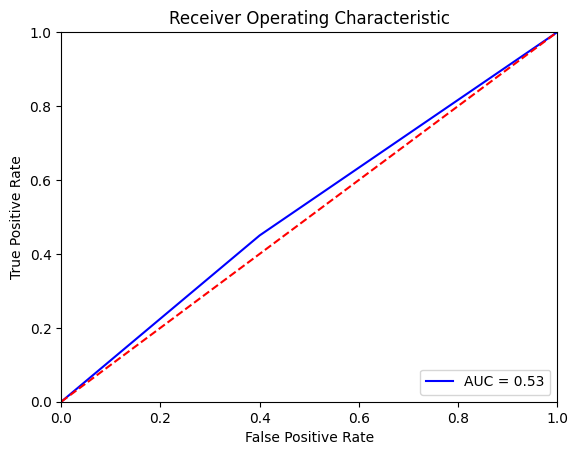

In [110]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC

import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We have an AUC score of 0.53 which tells us that our classifier has a very small class-seperation capacity which is not a good start, so clearly the bag-of-words transformation is not working.

### TF-IDF - SVM

For this section we will now do a tf-idf transformation and see if this transformation can create a better classifier, Tf-idf bassically counts the # of terms that occur in a document

In [111]:
## We are going to make a tf-idf with a bigram of 1 and 2
tfidf_transformer=TfidfVectorizer(ngram_range = (1,2))

## Pass the Text-object

## To make the td_idf
tf_idf_x = tfidf_transformer.fit_transform(X_train)

## Also transform the test-set using the same_vectorizer
tf_idf_test = tfidf_transformer.transform(X_test)

In [112]:
## So we have 160 rows and 39057 features transfromed
tf_idf_x.shape

(160, 39057)

In [113]:
## Again the matrix is sparse
tf_idf_x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Now I am going to implement SVM again with the tf-idf transformation

In [114]:
clf_svm_wv_i = svm.SVC(kernel = 'linear')
clf_svm_wv_i.fit(tf_idf_x,y_train)

SVC(kernel='linear')

In [115]:
#y_pred is the tf-idf transformation now
y_pred2 = clf_svm_wv_i.predict(tf_idf_test)

y_pred2

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [116]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred2)


# Likewise the accuracy score is the same as the bag of words transformation
print("Accuracy:", accuracy)

Accuracy: 0.475


AUC for our classifier is: 0.47500000000000003


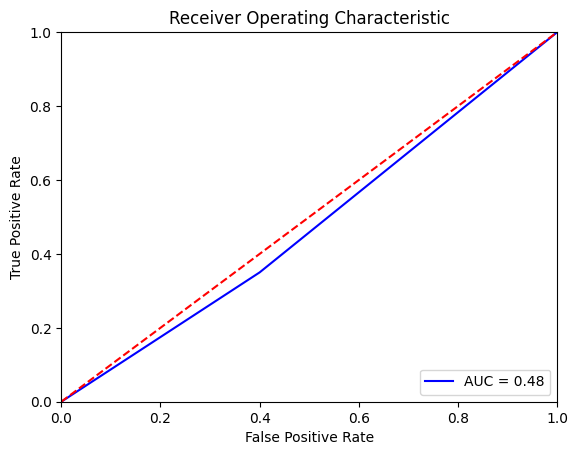

In [117]:
fpr, tpr, threshold = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC

import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Unfornatuely, it appears a tf-idf transformation has not worked as well and the AUC score is even lower.

### Word Vector - SVM

Word Vectors attempt to captures the semantic meaning of a word in a vector

Here I will attempt to use the word-vector transformation to see if it will help improve the model classification of the copies_sold column

I will use the spacy library in order to implement and use the word_vector algorithms

In [118]:
nlp = spacy.load("en_core_web_md")
docs = [nlp(text) for text in X_train]
train_x_word_vector = [x.vector for x in docs]

Here we will use SVM again this time using the word_vector transformation that captures the semantic meanings of our game description.

In [119]:
clf_svm_wv = svm.SVC(kernel = 'linear')
clf_svm_wv.fit(train_x_word_vector,y_train)

SVC(kernel='linear')

In [120]:
test_docs = [nlp(text) for text in X_test]
test_word_vector = [x.vector for x in test_docs]

y_pred3 = clf_svm_wv.predict(test_word_vector)

y_pred3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0])

Already the word-vector seems to be a slight improvement than the tf-idf and bag-of-words algorithm we can see the classifier trying to classify some games will not sell due to their description.

In [121]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred3)


# The score is still the same..
print("Accuracy:", accuracy)

Accuracy: 0.5


AUC for our classifier is: 0.49999999999999994


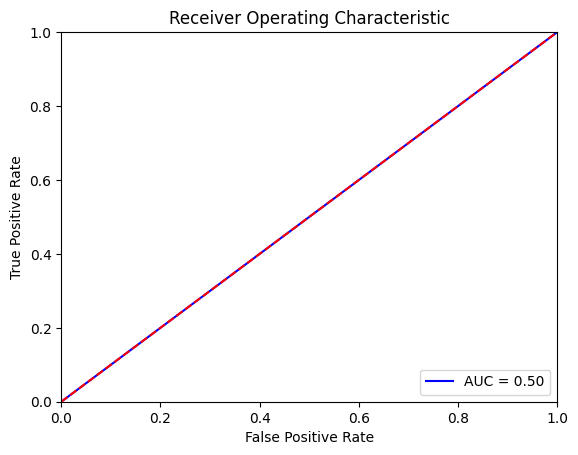

In [122]:
fpr, tpr, threshold = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC

import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Unfornateuly, the AUC score is not that high, with only a .4 increase but it appears the word-vector transformation seems to have done a slightly better job than the tf-idf but worse than bag-of-words transformation.

## Final Thoughts

Looking at the scope of the project and the work that I have done it appears that it is difficult to tell if a game will sell based on their description, from the transformations that I have used i.e (tf-idf,bag of words, and word vectors) it appears that word-vectors have only made a slight improvement in the classifier but it stil appears to have done a terrible job

Furthermore, the results of the SVM Model and the model we see that the predictions aren't doing well, this may stem from the fact that each utterance in the game description columns are unique from one another and thus the model have may have a difficult time predicting whether the game will sell, after all a horror game description may vary from a first-person shooter game description and thus it may be really difficult to predict whether the game will sell at all which could translate to a terrible classifier.

---
## Video Presentation

The code below allows a YouTube link to the video presentation to be inserted for the url variable and will then display the YouTube video within the notebook itself.

A regex match extracts the video ID from the URL which is then fed into the IPython package's built in Youtube embedder.

In [125]:
url = "https://youtu.be/lJIXAF4lz0M"

In [126]:
from IPython.display import YouTubeVideo
import re

reg = r"(?:v=|\/)([0-9A-Za-z_-]{11}).*"
urlid = re.search(reg, url)[1]

YouTubeVideo(urlid, width=800, height=450)

## Works Cited

Here is a list of sources I have consulted with for help on this project:

sklearn documentation for tf-idf: https://scikitlearn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform

svm documentation: https://scikit-learn.org/1.4/modules/generated/sklearn.svm.SVC.html

This guide I have used from analytics vidha to clean up text: https://www.analyticsvidhya.com/blog/2021/09/creating-a-movie-reviews-classifier-using-tf-idf-in-python/

NLP Tutorial for Word-Vectors from Keith Galli (gr8 tutorial btw.) https://www.youtube.com/watch?v=M7SWr5xObkA&ab_channel=KeithGalli

Gama-analytics API docs: https://gamalytic.com/api-reference.txt

Steam-API Help Docs: https://stackoverflow.com/questions/69512319/steam-api-to-get-game-info